In [ ]:
import h5py
# Apply spectral unmixing to dataset if it hasn't been done yet.
# (datasets uploaded to repository were not unmixed in advance).
with h5py.File("../data/phantoms/Processed_data/Scan_5.hdf5") as f:
    if "unmixed" not in f:
        !patato-unmix ../data/phantoms/Processed_data

In [1]:
from patato.io.msot_data import PAData
from patato.unmixing.unmixer import SpectralUnmixer

from os.path import join, exists

import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from utils import (
    normalise,
    severinghaus,
    load_new_po2,
    load_old_po2,
    FlowPhantomData,
    LearnedSO2Calculator,
)

import sys

sys.path.append("../simulations")
from learned_decolouring.ml import gbr_estimate, random_forest_estimate

In [2]:
# Define the data folder and where we will store the extracted values.

base_folder = "../data/phantoms"
output_file = "../data/phantoms/intermediate results/flow_spectrum_invision.pd"

MODEL_PATH = r"../simulations/learned_decolouring/models_GBR_all"

In [3]:
datasets = [
    ("Processed_data/Scan_5.hdf5", "20211202 - Run 1 (high melanin)", 0, 0),
    # ("Processed_data/Scan_6.hdf5", "20211202 - Run 2 (medium melanin)", 0),
    ("Processed_data/Scan_7.hdf5", "20211202 - Run 3 (medium melanin_2)", 0, 50),
    # ("Processed_data/Scan_4.hdf5", "20211125 - Run 0 (no melanin)/pO2 Probe Data", 0),
    # ("Processed_data/Scan_9.hdf5", "20211202 - Run 4 (low melanin_fail)", 0),
    ("Processed_data/Scan_11.hdf5", "20211203 - Run 5 (low melanin)", 66, 50),
]

# Extract measurements from the phantom data.

Check the mask alignment:

  0%|          | 0/3 [00:00<?, ?it/s]

dict_keys([('Reference Backprojection', '0')])
dict_keys([('Reference Backprojection', '0')])
dict_keys([('Reference Backprojection', '0')])


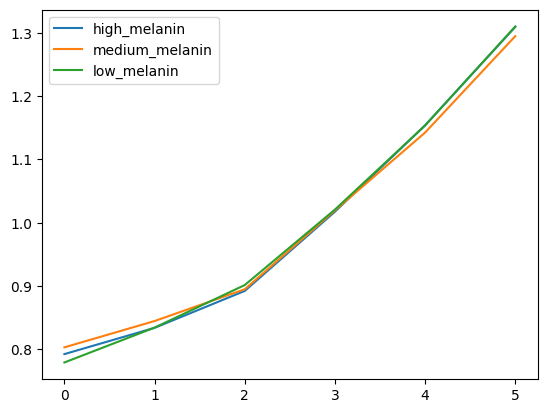

In [4]:
for pa_data, po2_data, manual_offset, crop in tqdm(datasets):
    pa_data = join(base_folder, pa_data)
    po2_data = join(base_folder, po2_data)
    f = FlowPhantomData.from_hdf5(pa_data, po2_data)[:, 2:13]
    print(f.get_scan_reconstructions().keys())
    f.set_default_recon(("Reference Backprojection", "0"))

    if ("unnamed_", "0") not in f.get_rois():
        continue

    # Define the po2 folder and pa_data folder.

    # f.get_scan_reconstructions()[:, 10:].imshow()
    roi_test = f.get_rois()[("unnamed_", "0")]
    mask, _ = roi_test.to_mask_slice(f.get_scan_reconstructions())
    # print(mask.shape, f.get_scan_reconstructions().shape)
    # f.get_scan_reconstructions().imshow(roi_mask=roi_test, cmap="hot")
    # plt.show()
    rec = f.get_scan_reconstructions()[0].raw_data
    s = np.mean(rec.T[mask.T].T, axis=1)[:6]
    plt.plot(s / np.mean(s), label=f.get_scan_name())
plt.legend()
plt.show()

In [5]:
rerun = True
if not exists(output_file) or rerun:
    results = []

    for pa_data, po2_data, manual_offset, crop in tqdm(datasets):
        # Define the po2 folder and pa_data folder.
        pa_data = join(base_folder, pa_data)
        po2_data = join(base_folder, po2_data)

        f = FlowPhantomData.from_hdf5(pa_data, po2_data)[
            :, 2:13
        ]  # Selecting desired wavelengths here.
        if "fail" in f.get_scan_name():
            continue
        f.po2_offset += manual_offset

        print(f.get_scan_name(), f.get_scan_datetime())

        # Get scan reconstructions.
        f.set_default_recon()
        rec = f.get_scan_reconstructions()

        # Do spectral unmixing.
        um = SpectralUnmixer(
            chromophores=["Hb", "HbO2"],
            wavelengths=f.get_wavelengths(),
            rescaling_factor=1,
        )
        unmixed, _, _ = um.run(rec, None)

        # Get the regions of interest.
        roi_test = f.get_rois()[("unnamed_", "0")]
        vessel, _ = roi_test.to_mask_slice(unmixed)

        # Calculate the blood oxygenation.
        so2 = unmixed.values[:, 1] / (unmixed.values[:, 0] + unmixed.values[:, 1])
        so2[so2 < 0] = np.nan
        so2[so2 > 1] = np.nan

        # Get some measurments
        result = {}
        result["unmixed_so2"] = so2.T[vessel.T].T[crop:]

        # Calculate the learned sO2:
        for model in tqdm(["SKIN"]):
            # Ignore warnings:
            import warnings

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                so2_b = LearnedSO2Calculator(model=model, model_path=MODEL_PATH)
                so2_b, _, _ = so2_b.run(rec, None)
            so2_b = so2_b.raw_data
            so2_b[so2_b < 0] = np.nan
            so2_b[so2_b > 1] = np.nan
            result[f"{model}_so2"] = np.squeeze(so2_b.T[vessel.T].T)[crop:]

        # Calculate a number of measurements:
        result["oxygenation"] = f.get_true_so2()[crop:]
        result["melanin"] = f.get_scan_name()
        result["spectrum"] = rec.values.T[vessel.T].T[crop:]
        result["mask"] = vessel
        result["wavelengths"] = f.get_wavelengths()
        result["time"] = (f.get_timestamps()[:, 0] - f.get_timestamps()[0, 0])[crop:]

        results.append(result)
    # Convert it into a data frame and then explode.
    df = pd.DataFrame(results)
    df = df.explode(
        column=["oxygenation", "spectrum", "time"]
        + [x for x in df.columns if "_so2" in x]
    )
    df.to_pickle(output_file)
else:
    df = pd.read_pickle(output_file)

  0%|          | 0/3 [00:00<?, ?it/s]

high_melanin 2021-12-02 13:37:38.707541


  0%|          | 0/1 [00:00<?, ?it/s]

0
medium_melanin 2021-12-02 15:24:44.958102


/tmp/ipykernel_895240/1575507495.py:36: RuntimeWarning: divide by zero encountered in divide
  so2 = unmixed.values[:, 1] / (unmixed.values[:, 0] + unmixed.values[:, 1])


  0%|          | 0/1 [00:00<?, ?it/s]

0
low_melanin 2021-12-03 10:42:01.326541


  0%|          | 0/1 [00:00<?, ?it/s]

66


The code below can be used to check the alignment between the po2 and so2 (i.e. were the scans started at the same time):

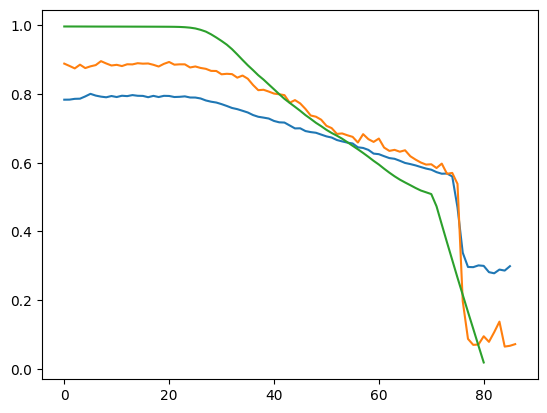

In [6]:
# align so2 with po2
lmdf = df[df["melanin"] == "high_melanin"]

pao2 = lmdf["unmixed_so2"].apply(np.median).values.astype(np.double)
lsd = lmdf["SKIN_so2"].apply(np.median).values.astype(np.double)
ox = lmdf["oxygenation"].values.astype(np.double) / 100

plt.plot(pao2[1:])
plt.plot(lsd)
plt.plot(ox)
plt.show()